In [1]:
import time
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator                           

In [2]:
train_dir = 'dataset/train'
val_dir = 'dataset/validation'
test_dir ='dataset/test'

IMG_SIZE = 299
BATCH = 16

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='sparse',  # Assumes one-hot encoded labels
    shuffle=True,
)

# Validation data generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='spars',  # Assumes one-hot encoded labels
    shuffle=True,
)

# Testing data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='spars',  # Assumes one-hot encoded labels
    shuffle=True,
)

classes = sorted(train_generator.class_indices.keys())
print(classes)

Found 432 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
['babi', 'sapi']


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3

# Define the base model with pre-trained weights
base_model = InceptionV3(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Freeze the base model with 50% of its layers
for layer in base_model.layers[:int(len(base_model.layers) * 0.5)]:
    layer.trainable = False

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x) 
predictions = Dense(2, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='spars',
              metrics=['accuracy'])

In [5]:
VAL_ACC_THRESHOLD = 0.90
VAL_LOSS_THRESHOLD = 0.01

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            val_acc = logs.get('val_accuracy')
            val_loss = logs.get('val_loss')
            if val_acc is not None and val_loss is not None:
                if val_acc > VAL_ACC_THRESHOLD and val_loss < VAL_LOSS_THRESHOLD:
                    print(f"\nVal_accuracy lebih dari {VAL_ACC_THRESHOLD*100}% dan val_loss kurang dari {VAL_LOSS_THRESHOLD}.")
                    self.model.stop_training = True

callbacks = CustomCallback()

In [7]:
# Record the start time
start_time = time.time()

# Model training
num_epochs = 100
history = model.fit(train_generator, 
                    epochs=num_epochs, 
                    validation_data=val_generator,
                    callbacks=[callbacks])

# Record the end time
end_time = time.time()
training_time = end_time - start_time
print(f'Training time: {training_time} seconds')

# Save the model
model.save('models/InceptionV3_0001_50.h5')

Epoch 1/100


C:\Users\hatha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8067 - loss: 0.5179 - val_accuracy: 0.7000 - val_loss: 0.5225
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9628 - loss: 0.1276 - val_accuracy: 0.8000 - val_loss: 0.5580
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9527 - loss: 0.1422 - val_accuracy: 0.9000 - val_loss: 0.4997
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9766 - loss: 0.0664 - val_accuracy: 0.9000 - val_loss: 0.2439
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9887 - loss: 0.0300 - val_accuracy: 0.9000 - val_loss: 0.2495
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9812 - loss: 0.0612 - val_accuracy: 0.8000 - val_loss: 0.4854
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9880 - loss: 0.0335 - val_accuracy: 0.8500 - val_loss: 0.4001
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9966 - loss: 0.0100 - val_accuracy: 0.8500 - val_loss: 0.2

Training time: 1807.9543175697327 seconds


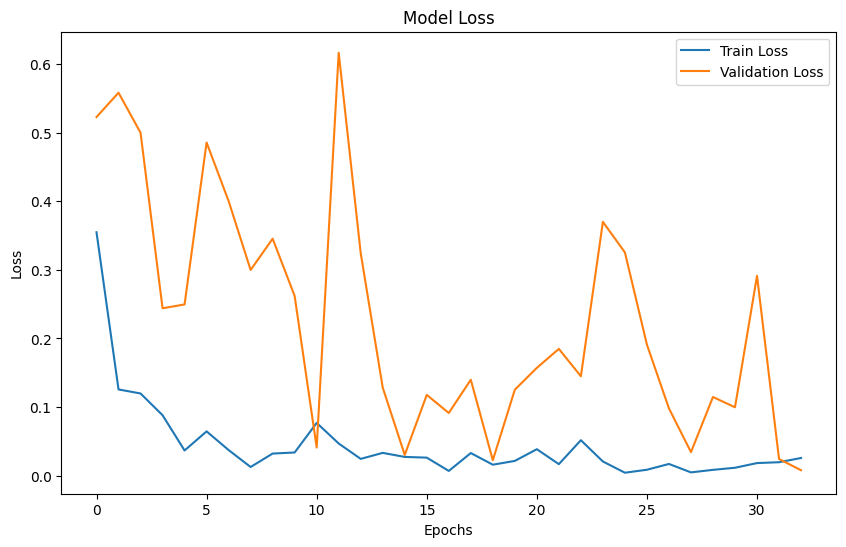

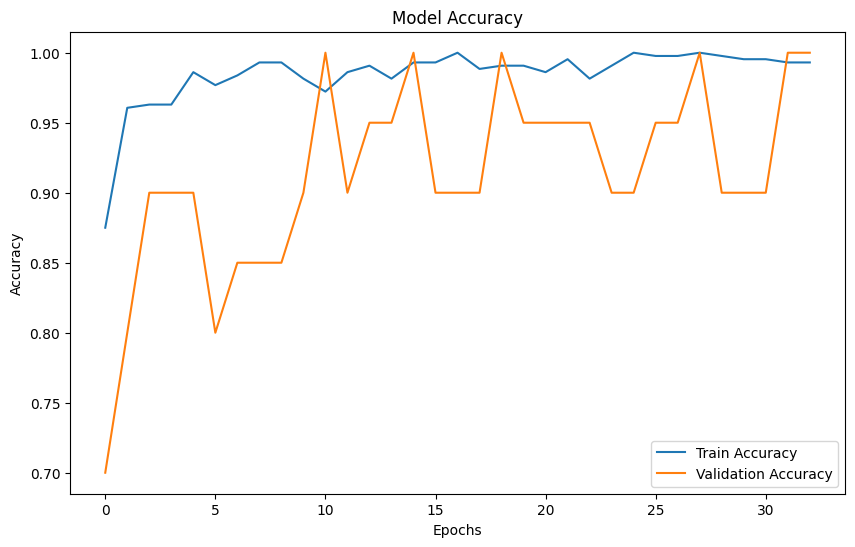

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step
Confusion Matrix:
[[6 4]
 [4 6]]


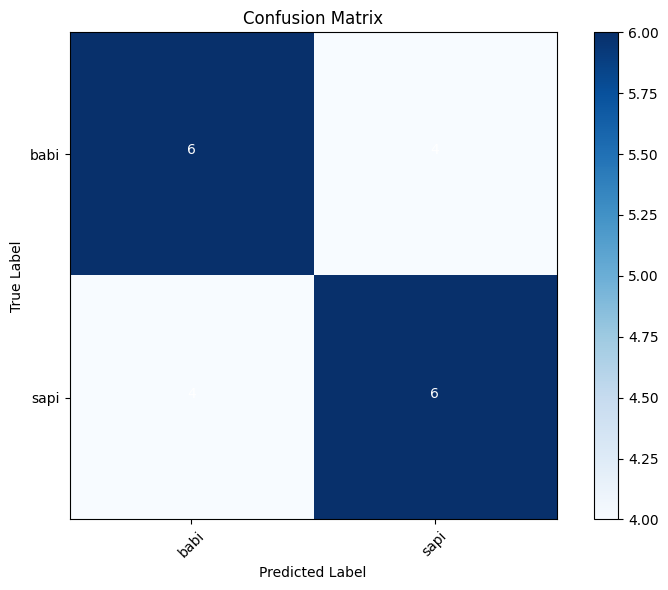

Classification Report:
              precision    recall  f1-score   support

        babi       0.60      0.60      0.60        10
        sapi       0.60      0.60      0.60        10

    accuracy                           0.60        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.60      0.60      0.60        20



In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get the true labels and predictions
true_labels = test_generator.classes
predictions = model.predict(test_generator).argmax(axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Add labels to the axes
classes = list(test_generator.class_indices.keys())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add the numbers on the squares
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f"{cm[i, j]}", horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=classes))